In [ ]:
# Importation des bibliothèques et des fonctions nécessaires
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import numpy as np
import glob
import h5py
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D
import shutil
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#!find /content/drive/MyDrive -type f \( -name "*.ipynb" -o -name "*.py" \)





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **I- Préprocessing**

## Application des masks sur les images

Ce processus consiste à appliquer des masques (s'il existe) sur les images radiographiques pour générer des images traitées. Les étapes incluent :

- Chargement des images et des masques : Les images sont lues depuis un répertoire spécifique et redimensionnées à (256, 256). Si un masque associé à l'image est disponible, il est également redimensionné pour correspondre à la taille de l'image.

- Application du masque : Le masque est appliqué sur l'image par multiplication élément par élément. Si aucun masque n'est trouvé, un masque noir (tout à zéro) est utilisé à la place.

- Sauvegarde des images traitées : Les images avec les masques appliqués sont sauvegardées dans un répertoire global, organisées par classe. Chaque image est encodée en PNG et enregistrée dans son sous-dossier respectif.

Cette méthode permet de créer un ensemble d'images prétraitées avec des masques appliqués pour une analyse ou une modélisation ultérieure.

In [ ]:
# ==============================
#  Dossiers principaux
# ==============================
# Spécification des répertoires utilisés pour les images de données, les masques, et les résultats globaux
base_dir = "/content/drive/MyDrive/project/COVID-19_Radiography_Dataset/"  # Dossier principal contenant les sous-dossiers par classe
mask_dir = "/content/drive/MyDrive/project/masks/"  # Dossier contenant les masques
global_dir = "/content/drive/MyDrive/project/global/"  # Dossier pour stocker les images traitées avec masques appliqués

# Créer le dossier global s'il n'existe pas déjà
os.makedirs(global_dir, exist_ok=True)

# Récupérer les noms des classes (ex: COVID, Lung_Opacity, Normal, Viral_Pneumonia)
# Liste des sous-dossiers dans base_dir (chaque sous-dossier représente une classe)
class_names = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Créer des sous-dossiers pour chaque classe dans global_dir
for class_name in class_names:
    os.makedirs(os.path.join(global_dir, class_name), exist_ok=True)

# ==============================
#  Fonction d’application de masque
# ==============================
def apply_mask(image_path, mask_path):
    """
    Applique un masque à une image donnée. Si le masque est absent, l'image reste inchangée.
    Le masque est redimensionné pour correspondre à la taille de l'image (256x256).
    """
    try:
        # Charger l'image
        image_raw = tf.io.read_file(image_path)  # Lecture de l'image à partir du chemin
        image = tf.image.decode_image(image_raw, channels=3)  # Décodage de l'image
        image = tf.image.resize(image, (256, 256))  # Redimensionner l'image

        # Charger le masque (ou masque noir si inexistant)
        if tf.io.gfile.exists(mask_path):  # Vérifier si le masque existe
            mask_raw = tf.io.read_file(mask_path)  # Lire le fichier du masque
            mask = tf.image.decode_image(mask_raw, channels=3)  # Décoder le masque
            mask = tf.image.resize(mask, (256, 256), method='nearest')  # Redimensionner le masque
            mask = tf.cast(mask, tf.float32) / 255.0  # Normaliser les valeurs du masque
        else:
            mask = tf.zeros([256, 256, 3], dtype=tf.float32)  # Si pas de masque, on crée un masque vide (noir)

        # Appliquer le masque sur l'image
        masked_image = tf.cast(image, tf.float32) * mask  # Appliquer l'élément-wise multiplication avec le masque
        masked_image = tf.clip_by_value(masked_image / 255.0, 0.0, 1.0)  # Normaliser à [0, 1]

        return masked_image  # Retourner l'image avec masque appliqué

    except Exception as e:
        # En cas d'erreur (par exemple, lecture ou décodage), on affiche l'erreur
        print(f"Erreur sur {os.path.basename(image_path)} : {e}")
        return None

# ==============================
#  Fonction pour traiter et sauvegarder
# ==============================
def process_and_save_images(base_dir, mask_dir, target_dir):
    """
    Fonction principale pour traiter toutes les images par classe, appliquer les masques et sauvegarder
    les images résultantes dans un dossier cible.
    """
    total_saved = 0  # Initialisation du compteur d'images sauvegardées

    for class_name in class_names:
        class_path = os.path.join(base_dir, class_name)  # Chemin vers le dossier de la classe spécifique

        # Vérifier si le sous-dossier 'images' existe, sinon utiliser le répertoire de classe directement
        images_path = class_path
        if os.path.exists(os.path.join(class_path, "images")):  # Si un dossier 'images' existe
            images_path = os.path.join(class_path, "images")

        # Lister les images dans le dossier de la classe
        images = [f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if len(images) == 0:
            print(f"Aucune image trouvée dans {images_path}")  # Si aucune image, on passe à la classe suivante
            continue

        saved_count = 0  # Compteur pour les images sauvegardées dans la classe en cours
        for img_name in images:
            image_path = os.path.join(images_path, img_name)  # Chemin complet de l'image

            # Chercher les différents noms de masques possibles associés à l'image
            possible_masks = [
                os.path.join(mask_dir, f"{class_name}_{img_name}"),  # Masque avec nom basé sur la classe et le nom de l'image
                os.path.join(mask_dir, img_name),  # Masque avec même nom que l'image
                os.path.join(mask_dir, f"mask_{img_name}")  # Masque avec préfixe 'mask_'
            ]
            # Trouver le premier masque existant parmi les options
            mask_path = next((m for m in possible_masks if tf.io.gfile.exists(m)), None)
            if mask_path is None:
                mask_path = ""  # Aucun masque trouvé, masque vide

            # Appliquer le masque à l'image
            masked_image = apply_mask(image_path, mask_path)
            if masked_image is None:
                continue  # Si l'image ne peut pas être traitée, on passe à la suivante

            # Sauvegarder l'image masquée
            save_path = os.path.join(target_dir, class_name, img_name)  # Chemin où sauvegarder l'image
            encoded = tf.image.encode_png(tf.cast(masked_image * 255, tf.uint8))  # Encoder en PNG
            tf.io.write_file(save_path, encoded)  # Sauvegarder l'image
            saved_count += 1  # Incrémenter le compteur pour cette classe
            total_saved += 1  # Incrémenter le compteur total

        print(f"Classe '{class_name}' : {saved_count} images sauvegardées dans {os.path.join(target_dir, class_name)}")

    # Afficher le nombre total d'images sauvegardées
    print(f"\nEnregistrement terminé avec succès : {total_saved} images traitées au total.")

# ==============================
#  Lancer le traitement
# ==============================
# Lancer le traitement de toutes les images du dataset avec l'application du masque et la sauvegarde des résultats
process_and_save_images(base_dir, mask_dir, global_dir)


Classe 'COVID' : 3616 images sauvegardées dans /content/drive/MyDrive/project/global/COVID
Classe 'Lung_Opacity' : 6012 images sauvegardées dans /content/drive/MyDrive/project/global/Lung_Opacity
Classe 'Normal' : 10192 images sauvegardées dans /content/drive/MyDrive/project/global/Normal
Classe 'Viral_Pneumonia' : 1345 images sauvegardées dans /content/drive/MyDrive/project/global/Viral_Pneumonia

 Enregistrement terminé avec succès : 21165 images traitées au total.


**Création du fichier global.h5**

<ul>

Cette étape fusionne tous les fichiers batch HDF5 en un seul fichier dataset_final.h5. Elle commence par calculer le nombre total d’images, puis crée un dataset HDF5 final avec la taille appropriée pour les images et les labels. Chaque batch est ensuite copié dans le fichier final, les labels sont convertis en entiers si nécessaire, et les fichiers batch originaux sont supprimés pour économiser de l’espace disque. Cela permet de disposer d’un dataset unique, facilement exploitable pour l’entraînement d’un modèle de deep learning.
</ul>

In [ ]:
# ==============================
#  Dossiers et paramètres
# ==============================
global_dir = "/content/drive/MyDrive/project/global/"
output_path = "/content/drive/MyDrive/project/global.h5"
img_size = (224, 224)
batch_size = 256

# Détection des classes
class_names = sorted([d for d in os.listdir(global_dir) if os.path.isdir(os.path.join(global_dir, d))])
num_classes = len(class_names)
print("Classes détectées :", class_names)

# Mapping nom → index
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

# ==============================
#  Comptage total des images
# ==============================
all_images = []
all_labels = []

for class_name in class_names:
    class_path = os.path.join(global_dir, class_name)
    imgs = [os.path.join(class_path, f) for f in os.listdir(class_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    all_images.extend(imgs)
    all_labels.extend([class_to_idx[class_name]] * len(imgs))

total_images = len(all_images)
print(f"Total d’images détectées : {total_images}")

# ==============================
#  Création du fichier HDF5 vide
# ==============================
with h5py.File(output_path, "w") as h5f:
    # Datasets vides préalloués
    X_dset = h5f.create_dataset(
        "X", shape=(total_images, img_size[0], img_size[1], 3),
        dtype=np.float32, compression="gzip"
    )
    y_dset = h5f.create_dataset("y", shape=(total_images,), dtype=np.int32, compression="gzip")

    h5f.attrs["class_names"] = np.array([np.bytes_(c) for c in class_names])

    print("Début du traitement par batchs...")

    # ==============================
    #  Traitement par batchs
    # ==============================
    for start in range(0, total_images, batch_size):
        end = min(start + batch_size, total_images)
        batch_paths = all_images[start:end]
        batch_labels = all_labels[start:end]

        batch_X = []
        for img_path in batch_paths:
            try:
                img_raw = tf.io.read_file(img_path)
                img = tf.image.decode_image(img_raw, channels=3)
                img = tf.image.resize(img, img_size)

                # Appliquer les transformations sur l'image
                img = tf.cast(img, tf.float32) / 255.0

                # Ajuster le contraste de l'image
                img = tf.image.adjust_contrast(img, contrast_factor=1.2)  # Augmente le contraste

                # Ajuster la luminosité de l'image
                img = tf.image.adjust_brightness(img, delta=0.1)  # Augmente la luminosité
                batch_X.append(img.numpy())
            except Exception as e:
                print(f"Erreur lecture {img_path} : {e}")
                # Remplacer par une image vide si erreur
                batch_X.append(np.zeros((img_size[0], img_size[1], 3), dtype=np.float32))

        batch_X = np.stack(batch_X, axis=0)

        # Écriture dans le HDF5
        X_dset[start:end] = batch_X
        y_dset[start:end] = batch_labels

        print(f"Batch {start//batch_size + 1}: {start}-{end} écrit ({len(batch_X)} images)")

print(f"\nFichier HDF5 final créé : {output_path}")
print(f"Contient {total_images} images réparties sur {num_classes} classes.")


Classes détectées : ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']
Total d’images détectées : 21165
Début du traitement par batchs...
Batch 1: 0-256 écrit (256 images)
Batch 2: 256-512 écrit (256 images)
Batch 3: 512-768 écrit (256 images)
Batch 4: 768-1024 écrit (256 images)
Batch 5: 1024-1280 écrit (256 images)
Batch 6: 1280-1536 écrit (256 images)
Batch 7: 1536-1792 écrit (256 images)
Batch 8: 1792-2048 écrit (256 images)
Batch 9: 2048-2304 écrit (256 images)
Batch 10: 2304-2560 écrit (256 images)
Batch 11: 2560-2816 écrit (256 images)
Batch 12: 2816-3072 écrit (256 images)
Batch 13: 3072-3328 écrit (256 images)
Batch 14: 3328-3584 écrit (256 images)
Batch 15: 3584-3840 écrit (256 images)
Batch 16: 3840-4096 écrit (256 images)
Batch 17: 4096-4352 écrit (256 images)
Batch 18: 4352-4608 écrit (256 images)
Batch 19: 4608-4864 écrit (256 images)
Batch 20: 4864-5120 écrit (256 images)
Batch 21: 5120-5376 écrit (256 images)
Batch 22: 5376-5632 écrit (256 images)
Batch 23: 5632-588

**Séparation des données en échantillons d'entraînement et de test.**

<ul>

- But général : préparer les données pour l'entraînement du modèle et son évaluation,
 en conservant la proportion des classes dans chaque ensemble.

- Paramètres clés :
<ul>

   - test_size=0.2 : 20 % des données pour le test, 80 % pour l'entraînement
 - stratify=y : assure que chaque classe est représentée proportionnellement
  - random_state=1234 : rend la séparation reproductible à chaque exécution

</ul>
</ul>

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import h5py

# ==============================
#  Paramètres
# ==============================
h5_path = "/content/drive/MyDrive/project/global.h5"
train_h5_path = "/content/drive/MyDrive/project/X_train.h5"
test_h5_path = "/content/drive/MyDrive/project/X_test.h5"
batch_size = 256

# ==============================
#  Charger uniquement les labels pour stratification
# ==============================
with h5py.File(h5_path, 'r') as h5f:
    y = h5f['y'][:]
    total_images = len(y)
    img_shape = h5f['X'].shape[1:]

# ==============================
#  Créer les indices train/test
# ==============================
indices = np.arange(total_images)
train_idx, test_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=y,
    random_state=1234
)

print(f"Train: {len(train_idx)} images, Test: {len(test_idx)} images")

# ==============================
#  Fonction pour créer HDF5 à partir des indices
# ==============================
def save_h5_from_indices(h5_input_path, h5_output_path, indices, batch_size=256, compression=None):
    total = len(indices)
    sorted_idx = np.sort(indices)  # Lecture triée = plus rapide sur disque

    with h5py.File(h5_input_path, 'r') as h5in, \
         h5py.File(h5_output_path, 'w') as h5out:

        X_in = h5in['X']
        y_in = h5in['y']
        img_shape = X_in.shape[1:]

        # Créer datasets de sortie
        X_dset = h5out.create_dataset(
            "X", shape=(total, *img_shape), dtype=np.float32, compression=compression
        )
        y_dset = h5out.create_dataset(
            "y", shape=(total,), dtype=np.int32, compression=compression
        )

        print(f"\nCréation de {h5_output_path} ({total} images)")
        for i, start in enumerate(range(0, total, batch_size), start=1):
            end = min(start + batch_size, total)
            batch_idx = sorted_idx[start:end]

            batch_X = X_in[batch_idx]
            batch_y = y_in[batch_idx]

            # Écrire directement (ordre identique car indices triés)
            X_dset[start:end] = batch_X
            y_dset[start:end] = batch_y

            print(f"Batch {i}: {start}-{end} écrit ({len(batch_X)} images)")

    print(f" Fichier créé : {h5_output_path}")

# ==============================
#  Exécution
# ==============================
save_h5_from_indices(h5_path, train_h5_path, train_idx, batch_size=batch_size)
save_h5_from_indices(h5_path, test_h5_path, test_idx, batch_size=batch_size)


Train: 16932 images, Test: 4233 images

Création de /content/drive/MyDrive/project/X_train.h5 (16932 images)
Batch 1: 0-256 écrit (256 images)
Batch 2: 256-512 écrit (256 images)
Batch 3: 512-768 écrit (256 images)
Batch 4: 768-1024 écrit (256 images)
Batch 5: 1024-1280 écrit (256 images)
Batch 6: 1280-1536 écrit (256 images)
Batch 7: 1536-1792 écrit (256 images)
Batch 8: 1792-2048 écrit (256 images)
Batch 9: 2048-2304 écrit (256 images)
Batch 10: 2304-2560 écrit (256 images)
Batch 11: 2560-2816 écrit (256 images)
Batch 12: 2816-3072 écrit (256 images)
Batch 13: 3072-3328 écrit (256 images)
Batch 14: 3328-3584 écrit (256 images)
Batch 15: 3584-3840 écrit (256 images)
Batch 16: 3840-4096 écrit (256 images)
Batch 17: 4096-4352 écrit (256 images)
Batch 18: 4352-4608 écrit (256 images)
Batch 19: 4608-4864 écrit (256 images)
Batch 20: 4864-5120 écrit (256 images)
Batch 21: 5120-5376 écrit (256 images)
Batch 22: 5376-5632 écrit (256 images)
Batch 23: 5632-5888 écrit (256 images)
Batch 24: 58

## Chargement et Préparation des Données pour l'Entraînement

<ul>

 But général :
 Charger efficacement les images et labels depuis un fichier HDF5 pour l'entraînement et la validation d'un modèle TensorFlow, sans charger tout le dataset en mémoire.
On prépare ici un pipeline "lazy loading" et optimisé pour GPU/TPU.
</ul>




1- Importation de train_test_split :
La bibliothèque train_test_split de sklearn.model_selection est utilisée pour diviser les indices des données en ensembles d'entraînement et de validation.

2- Paramètres :

- BATCH_SIZE : Taille des lots d'images qui seront envoyés au modèle lors de l'entraînement (32 dans cet exemple).

- H5_PATH : Chemin du fichier HDF5 contenant les données d'images et les labels.

3- Chargement des informations de base :

- On ouvre le fichier HDF5 pour récupérer le nombre d'échantillons, le nombre de classes et la forme des images.

- Les informations sont ensuite affichées : nombre d'images, nombre de classes, forme des images (224x224x3).

4- Chargement paresseux des labels encodés (y_encoded) :

- Les labels encodés (indices de classes) sont chargés en mémoire sous forme de tableau TensorFlow (y_encoded_tf).

5- Création d'un loader HDF5 paresseux (HDF5LazyLoader) :

- Une classe HDF5LazyLoader est définie pour permettre le chargement paresseux des données depuis le fichier HDF5. Cela permet de charger les images et les labels à la demande, ce qui est plus efficace en termes de mémoire pour les grands jeux de données.

6- Wrapper TensorFlow pour le chargement des données :

- La fonction tf_wrapper permet de transformer le loader HDF5 en un format compatible avec TensorFlow. Cette fonction est utilisée pour charger les images et les labels au sein d'un pipeline TensorFlow.

7- Split des Données (Entraînement/Validation) :

- Les indices des données sont mélangés et divisés en deux ensembles : un pour l'entraînement et un pour la validation, en utilisant train_test_split avec un ratio de 15% pour la validation.

8- Création des Dataset TensorFlow :

- Train Dataset :

Les indices d'entraînement sont utilisés pour créer un dataset TensorFlow. Les images sont chargées paresseusement, les données sont mélangées, puis traitées par lots.

- Validation Dataset :

De la même manière, les indices de validation sont utilisés pour créer un dataset TensorFlow.

9- Finalisation du Processus :

- Le dataset d'entraînement (train_dataset) et de validation (val_dataset) sont prêts à être utilisés dans le modèle. Ils sont configurés pour être préchargés en mémoire, ce qui améliore l'efficacité de l'entraînement.


In [ ]:
from sklearn.model_selection import train_test_split


# ==============================
#  Paramètres
# ==============================
BATCH_SIZE = 32
H5_PATH = '/content/drive/MyDrive/project/X_train.h5'

# === 1. Informations de base ===
with h5py.File(H5_PATH, "r") as f:
    y_encoded = f["y"][:]
    num_classes = len(np.unique(y_encoded))
    n_samples = f["X"].shape[0]
    img_shape = f["X"].shape[1:]  # (224,224,3)

print(f"Nombre d'images : {n_samples}")
print(f"Nombre de classes : {num_classes}")
print(f"Forme des images : {img_shape}")

# === 2. Chargement en mémoire des labels encodés ===
y_encoded_tf = tf.constant(y_encoded, dtype=tf.int64)

# === 3. Loader HDF5 paresseux ===
class HDF5LazyLoader:
    def __init__(self, path):
        self.file = h5py.File(path, "r")
        self.images = self.file["X"]
        self.labels = self.file["y"]

    def __call__(self, index):

        image = self.images[index].astype(np.float32)
        label = self.labels[index]
        return image, label

hdf5_dataset = HDF5LazyLoader(H5_PATH)

# === 4. Wrapper TensorFlow ===
def tf_wrapper(index):
    image, label = tf.numpy_function(
        func=hdf5_dataset,
        inp=[index],
        Tout=[tf.float32, tf.int32]
    )
    image.set_shape((224, 224, 3))
    label.set_shape(())
    return image, label

# ==============================
#  Split train / val
# ==============================
indices = np.arange(n_samples)
train_idx, val_idx = train_test_split(
    indices, test_size=0.15, random_state=1234, stratify=y_encoded
)

# === Train Dataset ===
train_dataset = tf.data.Dataset.from_tensor_slices(train_idx)
train_dataset = (train_dataset
    .shuffle(1000)
    .map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# === Validation Dataset ===
val_dataset = tf.data.Dataset.from_tensor_slices(val_idx)
val_dataset = (val_dataset
    .map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

print("train_dataset et val_dataset prêts.")


Nombre d'images : 16932
Nombre de classes : 4
Forme des images : (224, 224, 3)
train_dataset et val_dataset prêts.


# **II-Modélisation**

**Chargement du modèle DenseNet121 de tensorflow.keras.applications**


<ul>

**But général :**

 Utiliser un modèle DenseNet121 pré-entraîné sur ImageNet comme extracteur de caractéristiques et ajouter des couches entièrement connectées pour la classification en 4 classes de notre dataset.


</ul>

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

#  Charger DenseNet121 sans la tête finale (include_top=False)
# input_shape = (224,224,3) pour correspondre à nos images
# weights='imagenet' pour utiliser les poids pré-entraînés

densenet121 = DenseNet121(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

#  Geler le backbone DenseNet121
# On ne souhaite pas ré-entraîner les couches convolutionnelles du modèle pré-entraîné
# Cela permet d’utiliser les caractéristiques déjà apprises et réduit le temps d’entraînement

for layer in densenet121.layers:
    layer.trainable = False

# Construction de la tête du modèle personnalisé
x = densenet121.output
x = GlobalAveragePooling2D()(x)     # Transformation 2D → 1D en moyennant les cartes de caractéristiques
x = Dense(1024, activation='relu')(x)  # Couche dense avec 1024 neurones et activation ReLU
x = Dropout(0.2)(x)                 # Dropout pour réduire l’overfitting
x = Dense(512, activation='relu')(x)   # Deuxième couche dense de 512 neurones
x = Dropout(0.2)(x)                 # Dropout supplémentaire
output = Dense(4, activation='softmax')(x)  # Couche de sortie pour 4 classes avec softmax

# Définition du modèle complet
model = Model(inputs=densenet121.input, outputs=output)

# Affichage du résumé du modèle ---
# Utile pour vérifier le nombre de paramètres, la forme des couches et le blocage du backbone
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 8,613,956 (32.86 MB)

 Trainable params: 1,576,452 (6.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

- **Compilation du modele**

**But général :**

Débloquer certaines couches du modèle pré-entraîné pour permettre un ajustement plus fin (fine-tuning) sur notre dataset spécifique tout en conservant la majorité des poids pré-entraînés pour éviter l'overfitting.

In [ ]:
# Débloquer les 50 dernières couches du backbone
# Les couches initiales capturent des caractéristiques générales (bords, textures),
# tandis que les couches finales capturent des caractéristiques spécifiques à la tâche.
# On ne veut ré-entraîner que les couches finales pour adapter le modèle à notre dataset.

for layer in densenet121.layers[-50:]:
    layer.trainable = True


#  Compilation du modèle
# Optimiseur : Adam avec un learning rate très faible (1e-5) pour ne pas détruire
# les poids pré-entraînés déjà utiles.
# Loss : sparse_categorical_crossentropy car les labels sont sous forme d'entiers.
# Metrics : 'accuracy' pour suivre la performance du modèle lors de l'entraînement.

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

**Entrainement du modèle**

-  **But général :**

 Entraîner le modèle sur notre dataset en utilisant le fine-tuning partiel déjà défini, tout en gérant l'optimisation, le suivi et les déséquilibres de classes.


In [ ]:
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import CSVLogger

# ModelCheckpoint : sauvegarde automatique du meilleur modèle
# monitor='val_loss' → on sauvegarde le modèle qui minimise la perte sur la validation
# save_best_only=True → ne sauvegarde que le modèle avec la meilleure performance
# save_weights_only=False → sauvegarde le modèle complet (architecture + poids)
# mode='min' → on cherche à minimiser la perte

checkpoint = callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/project/H5PY/cnn_densenet121_masks_lazy_checkpoint.keras",
                                       monitor='val_loss',
                                       save_best_only=True,
                                       save_weights_only=False,
                                       mode='min',
                                       save_freq='epoch')


# ReduceLROnPlateau : réduit le learning rate automatiquement si la performance stagne
# patience=5 → attend 5 epochs avant de réduire
# factor=0.3 → divise le learning rate par 3 lorsqu’on le déclenche
# mode='min' → s’active lorsque la loss de validation ne diminue plus

lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         patience=5,
                                         factor=0.3,
                                         verbose=1,
                                         mode='min')

# ==============================
#  Calcul des poids de classes
# ==============================
# Nous calculons les poids de chaque classe pour gérer le déséquilibre entre les classes.
# L'idée est d'attribuer un poids plus élevé aux classes minoritaires et un poids plus faible aux classes majoritaires.
# Le LabelEncoder encode les étiquettes sous forme d'entiers pour les passer à la fonction compute_class_weight.
class_names = [d for d in os.listdir(GLOBAL_DIR) if os.path.isdir(os.path.join(GLOBAL_DIR, d))]
labels_list = []

# Récupérer les labels de toutes les images
for cls in class_names:
    cls_path = os.path.join(GLOBAL_DIR, cls)
    images = [f for f in os.listdir(cls_path) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    labels_list.extend([cls] * len(images))

# Encoder les labels
labels_array = np.array(labels_list)
le = LabelEncoder()
y_encoded = le.fit_transform(labels_array)  # Encodage des labels en entiers

# Calcul des poids des classes
classes_presentes = np.unique(y_encoded)  # Classes uniques dans les labels
class_weights = compute_class_weight(
    class_weight='balanced',               # Calcul des poids pour équilibrer les classes
    classes=classes_presentes,
    y=y_encoded
)

# Création du dictionnaire des poids de classes pour passer à l'entraînement
class_weight_dict = {cls: weight for cls, weight in zip(classes_presentes, class_weights)}

# Affichage des poids calculés pour chaque classe
print("Poids des classes :")
for cls_idx, weight in class_weight_dict.items():
    print(f"Classe '{le.inverse_transform([cls_idx])[0]}' ({cls_idx}) -> poids {weight:.3f}")


# Entraînement avec fit
# train_dataset et val_dataset sont des tf.data.Dataset optimisés
# class_weight=class_weight_dict → prend en compte l’équilibrage des classes
# callbacks=[lr_plateau, checkpoint] → assure le suivi et l'adaptation du learning rate
# epochs=10 → nombre d’itérations sur l’ensemble du dataset
csv_logger = CSVLogger("/content/drive/MyDrive/project/training_h5_log.csv", append=True)




history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[lr_plateau, checkpoint,csv_logger],
    class_weight=class_weight_dict
)


Poids des classes : {0: np.float64(1.4631870031109575), 1: np.float64(0.8802245789145352), 2: np.float64(0.5191317144959529), 3: np.float64(3.934014869888476)}
Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3335s 7s/step - accuracy: 0.5056 - loss: 1.0966 - val_accuracy: 0.7291 - val_loss: 0.6616 - learning_rate: 1.0000e-05
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1992s 4s/step - accuracy: 0.6980 - loss: 0.6534 - val_accuracy: 0.7772 - val_loss: 0.5710 - learning_rate: 1.0000e-05
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1962s 4s/step - accuracy: 0.7479 - loss: 0.5657 - val_accuracy: 0.7996 - val_loss: 0.5120 - learning_rate: 1.0000e-05
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1951s 4s/step - accuracy: 0.7755 - loss: 0.5036 - val_accuracy: 0.8102 - val_loss: 0.4845 - learning_rate: 1.0000e-05
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2011s 4s/step - accuracy: 0.7902 - loss: 0.4678 - val_accuracy: 0.8217 - val_loss: 0.4492 - learning_rate: 1.0000e-05
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2051s 4s/s

- **Afficher les courbes d'entraînement**

**But général :**

Suivre graphiquement la performance du modèle au cours des epochs pour détecter le sur-apprentissage, le sous-apprentissage ou tout problème d'entraînement.

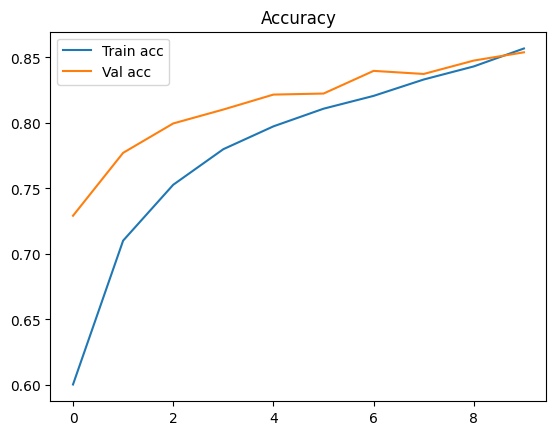

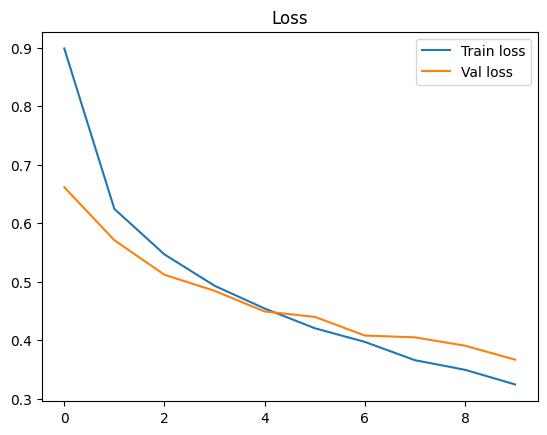

In [ ]:
# Récupération de l'historique depuis l'objet 'history' retourné par model.fit

history_dict = history.history

# Accuracy (précision)
# history_dict['accuracy'] → précision sur le jeu d'entraînement
# history_dict['val_accuracy'] → précision sur le jeu de validation
plt.plot(history_dict['accuracy'], label='Train acc')
plt.plot(history_dict['val_accuracy'], label='Val acc')
plt.legend()
plt.title("Accuracy")
plt.show()

# Loss (fonction de coût)
# history_dict['loss'] → loss sur le jeu d'entraînement
# history_dict['val_loss'] → loss sur le jeu de validation
plt.plot(history_dict['loss'], label='Train loss')
plt.plot(history_dict['val_loss'], label='Val loss')
plt.legend()
plt.title("Loss")
plt.show()

**Interprétation**

1. Phase initiale (0 à 2 epochs)

L’accuracy d’entraînement augmente rapidement : le modèle apprend vite.

La validation suit le même mouvement, ce qui signifie que l’apprentissage généralise bien au début.

2. Phase intermédiaire (de 3 à 6 epochs)

Les deux courbes progressent de façon parallèle.

Cela montre que le modèle continue à apprendre sans surajustement (overfitting).

La validation reste très proche de l’entraînement.

3. Phase finale (de 7 à 9 epochs)

Les deux courbes se stabilisent vers 0.85 (85 %).

L’écart entre entraînement et validation est faible (< 0.01). Celà signifie que le modèle est bien généralisé.

Pas de signe de surapprentissage (overfitting) ni de sous-apprentissage (underfitting).

# **III- Evaluation du modèle et interprètation des résultats**

In [ ]:
model =tf.keras.models.load_model('/content/drive/MyDrive/project/cnn_densenet121_modele_masksh5.keras')

- **Chargement des données du test pour les prédictions**

**But général :**

Préparer les images et labels de test pour évaluer le modèle après entraînement.

In [ ]:
# ==============================
#  Paramètres
# ==============================
TEST_H5_PATH = "/content/drive/MyDrive/project/X_test.h5"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# ==============================
#  Loader HDF5 pour test
# ==============================
class HDF5TestLoader:
    def __init__(self, path):
        self.file = h5py.File(path, "r")
        self.images = self.file["X"]
        self.labels = self.file["y"]

    def __call__(self, index):

        image = self.images[index].astype(np.float32)
        label = self.labels[index]
        return image, label

test_loader = HDF5TestLoader(TEST_H5_PATH)

# ==============================
#  Wrapper TensorFlow
# ==============================
def tf_wrapper_test(index):
    image, label = tf.numpy_function(
        func=test_loader,
        inp=[index],
        Tout=[tf.float32, tf.int32]
    )
    image.set_shape((224, 224, 3))
    label.set_shape(())
    return image, label

# ==============================
#  Création du dataset
# ==============================
with h5py.File(TEST_H5_PATH, "r") as f:
    n_samples = f["X"].shape[0]

indices = np.arange(n_samples)

test_dataset = tf.data.Dataset.from_tensor_slices(indices)
test_dataset = test_dataset.map(tf_wrapper_test, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f" Test dataset prêt : {n_samples} images, batch_size={BATCH_SIZE}")


 Test dataset prêt : 4233 images, batch_size=32


- **Évaluation du modèle**

**But général :**
Utiliser le modèle entraîné pour prédire les classes des images de test.

In [ ]:
# =====================================================================
# Évaluation du modèle sur les données de test
# =====================================================================

from sklearn.metrics import classification_report, confusion_matrix

# ---------------------------------------------------------------------
# Fonction pour extraire :
# - les vraies étiquettes (true_labels)
# - les prédictions du modèle (pred_labels)
# - les probabilités associées à chaque classe (pred_probs)
# ---------------------------------------------------------------------
def get_predictions_labels_probs(dataset, model):
    true_labels = []
    pred_labels = []
    pred_probs = []

    # Parcourt le jeu de test par batch
    for images, labels in dataset:
        # Prédit les probabilités pour chaque classe
        preds = model.predict(images, verbose=0)

        # Stocke les probabilités (utile pour ROC, AUC, etc.)
        pred_probs.extend(preds)

        # Convertit les probabilités en labels (classe avec la plus forte proba)
        pred_labels.extend(np.argmax(preds, axis=-1))

        # Stocke les vraies étiquettes
        true_labels.extend(labels.numpy())

    # Retourne les trois tableaux sous forme numpy
    return np.array(true_labels), np.array(pred_labels), np.array(pred_probs)


# ---------------------------------------------------------------------
# Application de la fonction au jeu de test
# ---------------------------------------------------------------------
y_true, y_pred, y_prob = get_predictions_labels_probs(test_dataset, model)

# ---------------------------------------------------------------------
# Rapport de classification
# ---------------------------------------------------------------------
# Affiche la précision, le rappel et le F1-score pour chaque classe,
# ainsi que les moyennes globales (macro / weighted).
# Permet d’évaluer le comportement du modèle par classe.
print(classification_report(y_true, y_pred))

# ---------------------------------------------------------------------
# Matrice de confusion
# ---------------------------------------------------------------------
# Montre le nombre de prédictions correctes et incorrectes pour chaque classe.
# Les diagonales représentent les bonnes prédictions.
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.76      0.76      0.76       723
           1       0.85      0.82      0.84      1203
           2       0.89      0.90      0.90      2038
           3       0.89      0.96      0.92       269

    accuracy                           0.86      4233
   macro avg       0.85      0.86      0.85      4233
weighted avg       0.86      0.86      0.86      4233

[[ 552   78   89    4]
 [  91  988  123    1]
 [  86   91 1834   27]
 [   0    3    9  257]]




<hr style="border: 1px solid #0080ff;">

$$\text{Rapport de classification}$$

<hr style="border: 1px solid #0080ff;">

Le modèle montre des performances globales excellentes :

<ul>

**Précision :**

<ul>
<div style="border-left: 5px solid #00ffbf; padding: 10px; background: white;">

La précision pour chaque classe est élevée (supérieure à 76% pour toutes les classes), ce qui indique que le modèle fait relativement peu d'erreurs lorsqu'il prédit une classe positive.

</div>
</ul>


**Rappel :**

<ul>
<div style="border-left: 5px solid #00ffbf; padding: 10px; background: white;">

Le modèle a un excellent rappel pour la classe 3 (Viral_Pneumonia) avec un rappel de 96%, ce qui signifie qu'il identifie la plupart des instances de cette classe.


Le rappel est également bon pour les autres classes.

</div>
</ul>




**F1-Score :**

<ul>
<div style="border-left: 5px solid #00ffbf; padding: 10px; background: white;">

Le F1-score est très bon pour toutes les classes (autour de 86%), ce qui montre un bon compromis entre précision et rappel.

</div>
</ul>


**Accuracy :**

<ul>
<div style="border-left: 5px solid #00ffbf; padding: 10px; background: white;">

L'accuracy globale est de 86%, ce qui est un très bon résultat pour un modèle de classification d'images. Cela signifie que le modèle fait une prédiction correcte pour environ 86% des images.

</div>
</ul>



**Classement des classes :**

<ul>

<div style="border-left: 5px solid #00ffbf; padding: 10px; background: white;">

Classe 0 (COVID) : Le modèle a une précision de 76% et un rappel de 76%.



Classe 1 (Lung_Opacity) : La précision est de 85%, et le rappel est de 84%.


Classe 2 (Normal) : Précision de 86%, rappel de 90%.


Classe 3 (Viral_Pneumonia) : Précision de 89%, rappel de 96%.

</div>
</ul>
</ul>

<hr style="border: 1px solid #0080ff;">

$$\text{Matrice de confusion}$$
<hr style="border: 1px solid #0080ff;">
<ul>

La matrice de confusion montre les performances du modèle de manière plus détaillée, et les résultats sont très bons :

| Réel \\ Prédit | COVID | Lung_Opacity | Normal | Viral_Pneumonia |
|----------------|:------:|:-------------:|:-------:|:----------------:|
| **COVID** | **552** | 78 | 89 | 4 |
| **Lung_Opacity** | 91 | **988** | 123 | 1 |
| **Normal** | 86| 91 | **1834** | 27 |
| **Viral_Pneumonia** | 0 | 0 | 3 | **257** |

</ul>

<hr style="border: 1px solid #0080ff;">

$$\text{Interprétation}$$

<hr style="border: 1px solid #0080ff;">
<ul>

**. Classe 0 (COVID) :**

<ul>

552 images de COVID ont été correctement classées comme COVID.


Quelques erreurs de classification (78 images mal classées en Lung_Opacity, 89 en Normal, et 4 en Viral_Pneumonia), mais dans l'ensemble, les erreurs sont relativement faibles.

</ul>


**. Classe 1 (Lung_Opacity) :**

<ul>

La majorité des images de Lung_Opacity sont correctement classées (988).


123 images de cette classe sont mal classées en Normal, ce qui est l'une des erreurs principales.

</ul>



**. Classe 2 (Normal) :**

<ul>

1834 images sont correctement classées comme Normal.


Il y a un nombre raisonnable d'images mal classées dans Lung_Opacity (91), mais la majorité des prédictions sont correctes.

</ul>



**. Classe 3 (Viral_Pneumonia) :**

<ul>

Très peu d'erreurs pour Viral_Pneumonia, avec seulement 3 images mal classées en Normal.


Cela montre que le modèle fait un excellent travail pour identifier les cas de Viral_Pneumonia.
</ul>


</ul>

<hr style="border: 1px solid #0080ff;">

$$\text{Conclusion}$$

<hr style="border: 1px solid #0080ff;">
<ul>

Le modèle a maintenant des performances très bonnes. Les résultats de la précision, du rappel et du F1-score montrent que le modèle prédit correctement la plupart des classes, en particulier la classe Viral_Pneumonia avec un rappel de 96%.


Les erreurs de classification restantes sont principalement dues à des confusions entre des classes similaires (par exemple, Lung_Opacity et Normal), ce qui est normal dans les tâches de classification d'images complexes.


</ul>
</ul>



- **confusion avec normalisation**

**But général :**

Vérifier quantitativement les performances du modèle sur le dataset de test.
La matrice de confusion montre combien d'échantillons de chaque classe ont été correctement ou incorrectement classés.


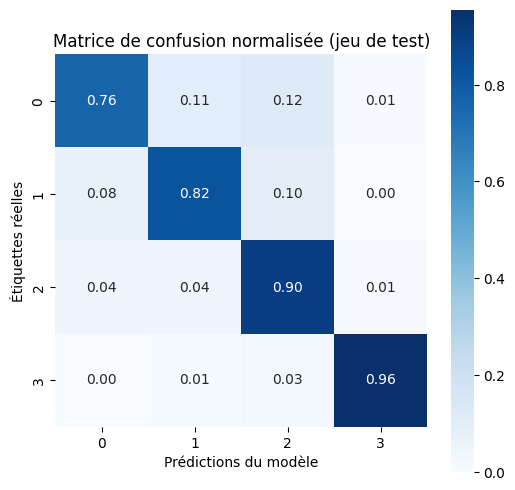

In [ ]:
# =====================================================================
# Visualisation de la matrice de confusion normalisée
# =====================================================================

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ---------------------------------------------------------------------
# Calcul de la matrice de confusion
# ---------------------------------------------------------------------
# La matrice de confusion compare les prédictions du modèle (y_pred)
# aux vraies étiquettes (y_true).
# L’option normalize='true' permet de normaliser les valeurs par ligne,
# c’est-à-dire que chaque ligne (classe réelle) somme à 1.
# Cela permet de visualiser les proportions plutôt que les valeurs absolues.
cnf_matrix = confusion_matrix(y_true, y_pred, normalize='true')

# ---------------------------------------------------------------------
# Affichage de la matrice de confusion
# ---------------------------------------------------------------------
# On utilise seaborn.heatmap pour représenter la matrice sous forme colorée.
# - annot=True : affiche les valeurs dans les cases
# - fmt=".2f" : deux décimales
# - cmap="Blues" : palette de couleur bleue
# - square=True : cases carrées pour une présentation plus claire
plt.figure(figsize=(6, 6))
sns.heatmap(cnf_matrix, annot=True, fmt=".2f", cmap="Blues", square=True)

# Étiquettes et titre
plt.xlabel("Prédictions du modèle")
plt.ylabel("Étiquettes réelles")
plt.title("Matrice de confusion normalisée (jeu de test)")

plt.show()


**Interprétation**

<ul>

**.** Le modèle est globalement très performant, avec des taux de bonne classification supérieurs à 76% pour toutes les classes.

**.** Les classes  Viral_Pneumonia est particulièrement bien reconnue (96 % ).

**.** Les classes COVID,  Lung_Opacity et Normal présentent un peu plus de confusion entre elles, ce qui peut être cohérent sur le plan médical (leurs radiographies peuvent être visuellement similaires).

</ul>



* **Visualisation: Inspection de quelques prédictions**

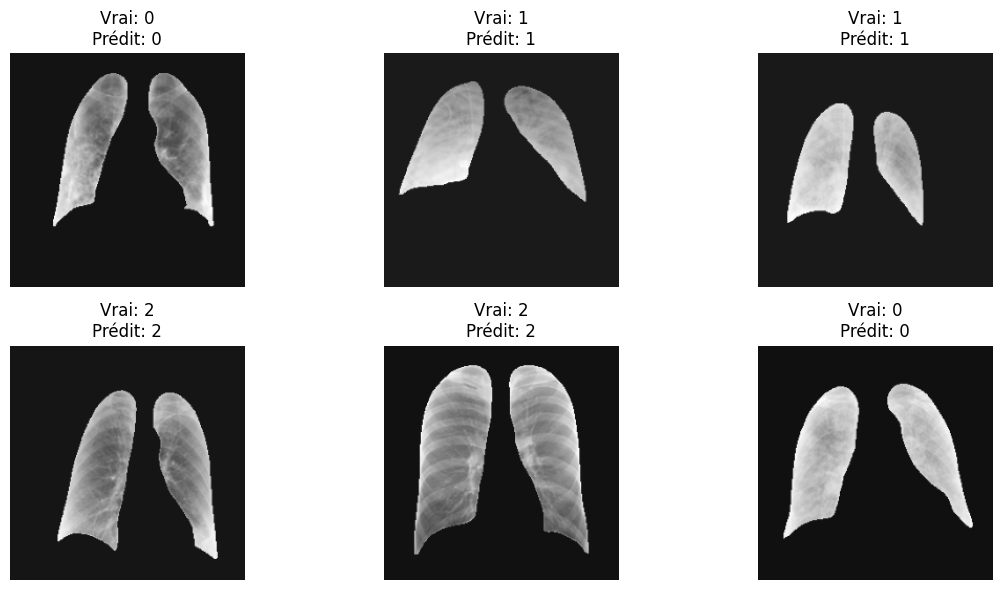

In [ ]:
# Nombre d'images à afficher
num_images = 6

# Récupérer toutes les images du dataset test_ds (batché)
all_images = []
for batch_images, _ in test_dataset:
    all_images.append(batch_images.numpy())
all_images = np.concatenate(all_images, axis=0)

# Normalisation de chaque image dans all_images pour la ramener dans la plage [0, 1]
for i in range(len(all_images)):
    # Diviser chaque image par sa valeur maximale
    all_images[i] = all_images[i] / all_images[i].max()

# Tirer 6 indices aléatoires
indices = np.random.choice(len(y_true), num_images, replace=False)

# Affichage des images
plt.figure(figsize=(12, 6))

for i, idx in enumerate(indices):
    plt.subplot(2, 3, i + 1)  # 2 lignes, 3 colonnes
    plt.imshow(all_images[idx])
    plt.title(f"Vrai: {y_true[idx]}\nPrédit: {y_pred[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()



- **Courbe des valeurs réelles vs prédites**

**But général :**

 Comparer visuellement les prédictions du modèle (y_pred) avec les vraies étiquettes (y_test) sur un sous-échantillon pour identifier facilement les erreurs.

In [ ]:
import numpy as np
import plotly.graph_objects as go

# Définition des classes
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']

# Convertir y_true et y_pred en indices de classes
y_true_indices = y_true
y_pred_indices = y_pred

# Créer un sous-ensemble équilibré avec un nombre d'exemples fixe par classe
subset_size_per_class = 25  # Nombre d'exemples par classe dans le sous-ensemble
indices_balanced = []

# Sélectionner un nombre fixe d'exemples pour chaque classe
for i in range(len(class_names)):
    class_indices = np.where(y_true_indices == i)[0]
    if len(class_indices) >= subset_size_per_class:
        selected_indices = np.random.choice(class_indices, subset_size_per_class, replace=False)
    else:
        selected_indices = class_indices
    indices_balanced.extend(selected_indices)

indices_balanced = np.array(indices_balanced)
np.random.shuffle(indices_balanced)

# Vérification de la taille de indices_balanced pour éviter l'IndexError
print(f"Taille du sous-ensemble équilibré: {len(indices_balanced)}")

# Sous-ensemble de données équilibré
y_true_subset = y_true_indices[indices_balanced]
y_pred_subset = y_pred_indices[indices_balanced]

# Créer le graphique
fig = go.Figure()

# Points correctement classés
correct_mask = y_true_subset == y_pred_subset
incorrect_mask = y_true_subset != y_pred_subset

correct_indices = indices_balanced[correct_mask]
incorrect_indices = indices_balanced[incorrect_mask]

# Points correctement classés
fig.add_trace(go.Scatter(
    x=correct_indices,
    y=y_true_subset[correct_mask],
    mode='markers',
    name='Correctement classé',
    marker=dict(size=8, color='#00ff00', symbol='circle'),
    text=[f"Réel: {class_names[y]}, Prédit: {class_names[y_pred_subset[i]]}"
          for i, y in enumerate(y_true_subset[correct_mask])],
    hovertemplate='Index: %{x}<br>%{text}<extra></extra>'
))

# Points mal classés
fig.add_trace(go.Scatter(
    x=incorrect_indices,
    y=y_true_subset[incorrect_mask],
    mode='markers',
    name='Mal classé',
    marker=dict(size=8, color='#e60000', symbol='x'),
    text=[f"Réel: {class_names[y_true_subset[i]]}, Prédit: {class_names[y_pred_subset[i]]}"
          for i in np.where(incorrect_mask)[0]],
    hovertemplate='Index: %{x}<br>%{text}<extra></extra>'
))

# Modifier l'axe y pour afficher les classes de manière parallèle
fig.update_yaxes(
    tickvals=np.arange(len(class_names)),
    ticktext=class_names,
    title_text="Classe réelle",
    range=[-0.5, len(class_names) - 0.5]  # Ajuster pour que les classes soient centrées sur l'axe
)

fig.update_layout(
    title=f"Valeurs correctement et incorrectement classées sur {len(indices_balanced)} échantillons",
    xaxis_title="Index des échantillons",
    width=1000,
    height=600,
    showlegend=True
)

fig.show()


Taille du sous-ensemble équilibré: 100


- **Courbes ROC et AUC pour la classe COVID-19**

**But général :**

Évaluer la capacité du modèle à distinguer les images positives (COVID) des négatives pour cette classe.

La courbe ROC (Receiver Operating Characteristic) montre le compromis entre le taux de vrais positifs (TPR) et le taux de faux positifs (FPR).


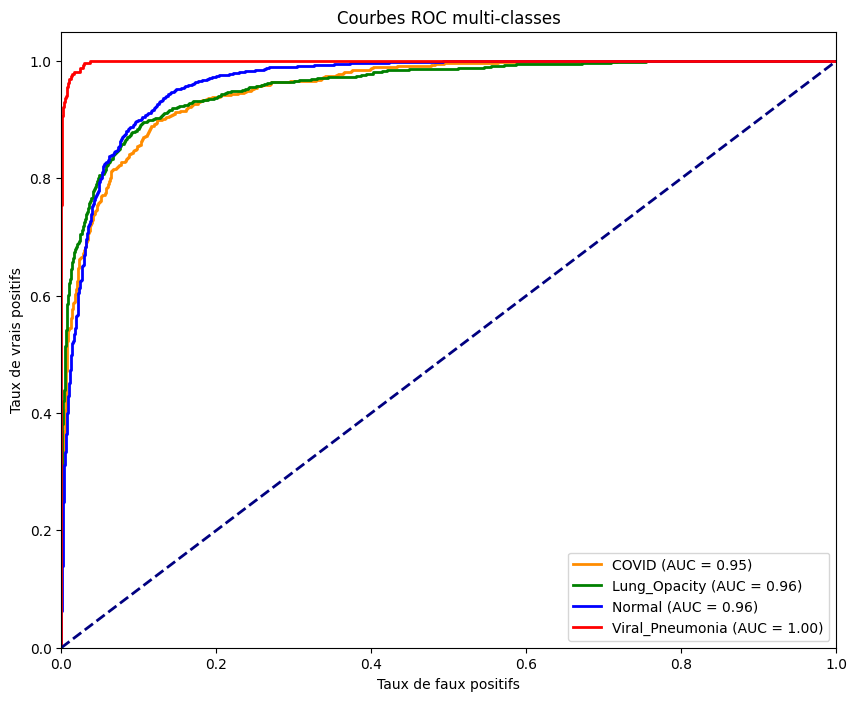

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binariser les vraies étiquettes
y_true_bin = label_binarize(y_true, classes=[0,1,2,3])

class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']
colors = ['darkorange', 'green', 'blue', 'red']

plt.figure(figsize=(10, 8))

for i in range(4):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC multi-classes')
plt.legend(loc="lower right")
plt.show()


Ce que cette figure montre :

La courbe ROC montre le compromis entre les faux positifs et les vrais positifs.

L'AUC (Area Under the Curve) donne une mesure globale de la performance du modèle. Une AUC de 1 indique un modèle parfait, tandis qu'une AUC de 0.5 suggère une performance aléatoire.

**Interprétation**

Dàprès cette courbe ROC, nous constatons que :
<ul>

**.** le modèle détecte presque correctement les cas COVID-19.

**.** le modèle fait très peu d'erreurs(peu de faux positifs et faux négatifs)

**.** le modèle est  fiable pour la classe COVID-19 selon les données testées.

</ul>

- **Distribution des erreurs de prédiction**

**But général :**

 Identifier quelles classes sont les plus sujettes aux erreurs de prédiction.

 Cette étape permet de diagnostiquer les points faibles du modèle.

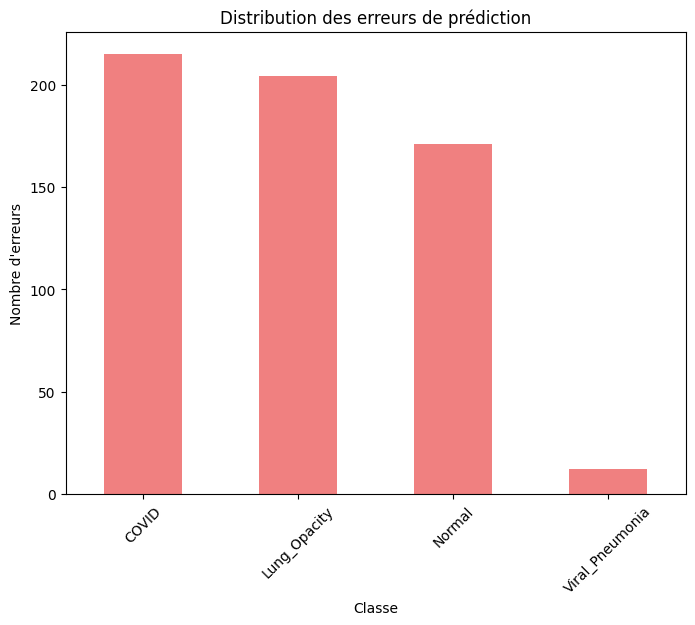

In [ ]:
import pandas as pd

# Créer un DataFrame des prédictions et des vraies valeurs
predictions_df = pd.DataFrame({'true': y_true, 'pred': y_pred})

# Sélectionner les erreurs
errors = predictions_df[predictions_df['true'] != predictions_df['pred']]

# Afficher la distribution des erreurs par classe
errors_count = errors['true'].value_counts()

# Créer la figure
plt.figure(figsize=(8, 6))
errors_count.plot(kind='bar', color='lightcoral')
plt.title("Distribution des erreurs de prédiction")
plt.xlabel("Classe")
plt.ylabel("Nombre d'erreurs")
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.show()


**Interprétation**

Dàprès cette distribution, nous observons que :

<UL>

**Classe COVID-19** :

C’est celle où le modèle fait le plus d’erreurs (~220).

Cela signifie qu’il confond souvent les images COVID avec d’autres classes (probablement Lung_Opacity ou Normal).

**Classe Lung Opacity** :

Deuxième source d’erreurs (~210).

Ces images sont aussi difficiles à distinguer pour le modèle.

**Classe Normal** :

Moins d’erreurs (~180).

Le modèle reconnaît plutôt bien les cas normaux.

**Classe Viral Pneumonia** :

Très peu d’erreurs (~10).

Le modèle est assez fiable pour cette catégorie.

</UL>

- **Visualisation des erreurs de classification**

**But général :**

Identifier et analyser les images que le modèle a mal classées.

Cela aide à comprendre les types d'erreurs que le modèle fait et à guider d'éventuelles améliorations.


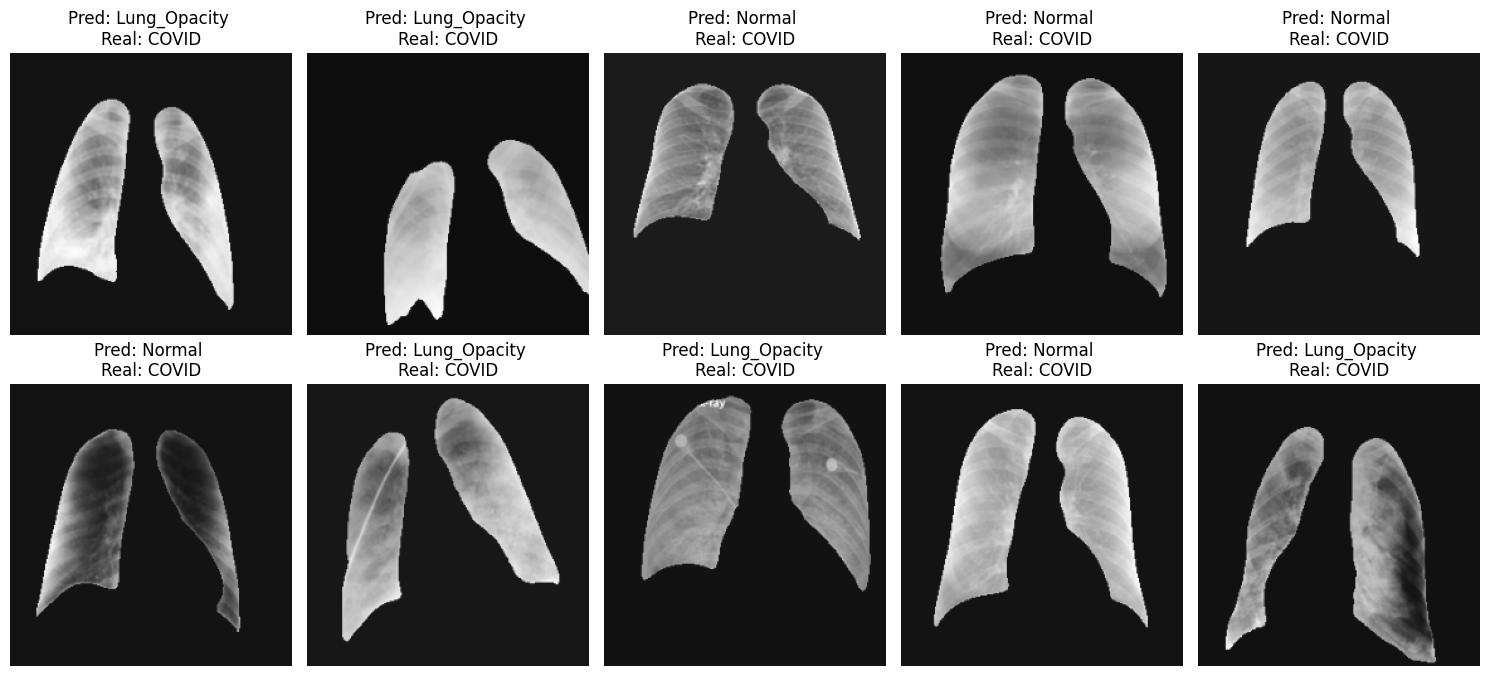

In [ ]:
# === 1. Identifier les erreurs ===
wrong_predictions = np.where(y_pred != y_true)[0]
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']
# === 2. Extraire toutes les images du dataset (batches concaténés) ===
all_images = []
for batch_images, _ in test_dataset:
    all_images.append(batch_images.numpy())
all_images = np.concatenate(all_images, axis=0)

# === 3. Afficher les 10 premières images mal classées ===
plt.figure(figsize=(15, 7))
for i, idx in enumerate(wrong_predictions[:10]):
    plt.subplot(2, 5, i + 1)

    # Récupérer l'image correspondante
    image = all_images[idx]
    image = image / image.max()

    # Si l'image est normalisée [0,1], remettre en [0,255] pour affichage
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)

    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Pred: {class_names[int(y_pred[idx])]} \nReal: {class_names[int(y_true[idx])]}")

plt.tight_layout()
plt.show()


# Grad-CAM (Gradient-weighted Class Activation Mapping)

Dans cette section, nous sélectionnons une image par classe et générons leurs cartes de chaleur (Heatmap) de Grad-CAM ainsi que leurs superpositions (Overlay).

Model loaded. input shape = (None, 224, 224, 3)
Dernière couche Conv2D utilisée pour Grad-CAM : **conv5_block16_2_conv**


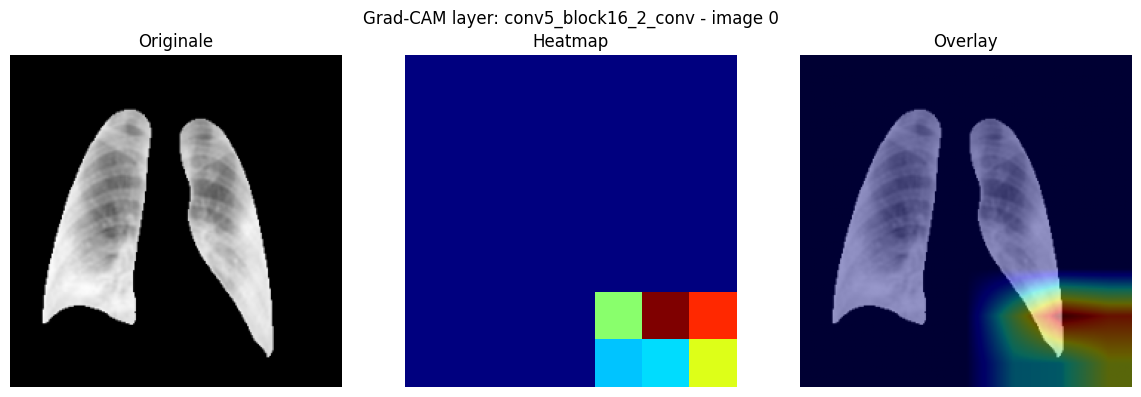

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Image 0 -> classe prédite: 1 (p=0.509)


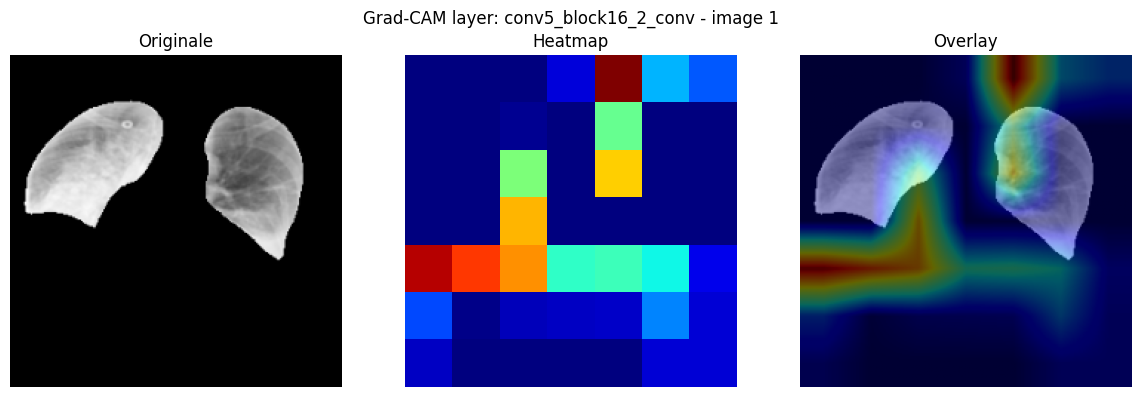

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
Image 1 -> classe prédite: 1 (p=0.906)


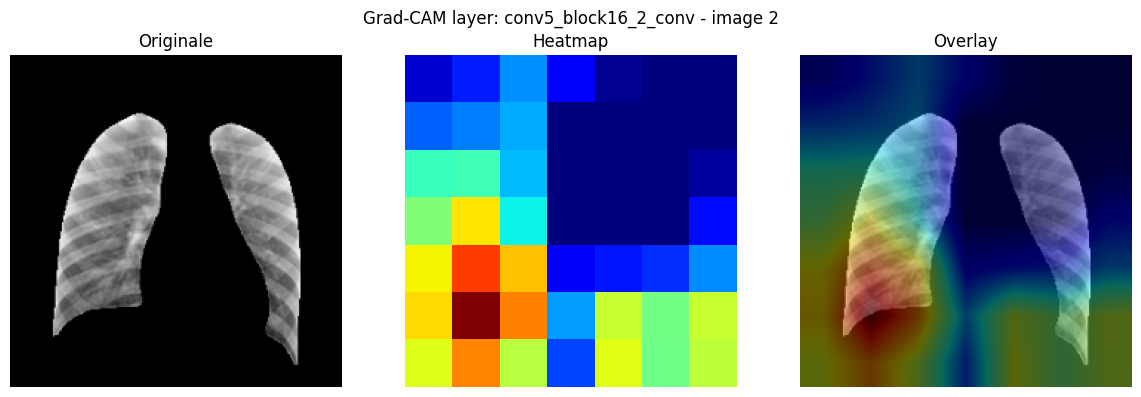

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
Image 2 -> classe prédite: 3 (p=0.931)


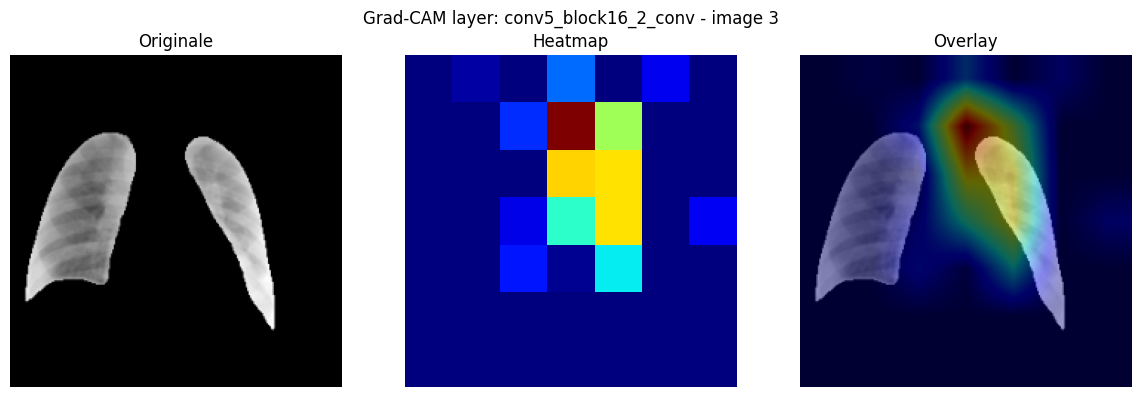

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Image 3 -> classe prédite: 1 (p=0.612)


In [ ]:
# -------------------------
#  UTILITAIRES
# -------------------------
def preprocess_image(img, target_size=None):
    """Prétraitement basique : convertir en float32 et normaliser entre 0-1."""
    img = img.astype(np.float32)
    if img.ndim == 2:
        img = np.expand_dims(img, -1)  # H,W,1
    if img.shape[-1] == 1:
        img = np.concatenate([img, img, img], axis=-1)  # convertir en 3 canaux
    if target_size is not None:
        img = tf.image.resize(img, target_size).numpy()
    img = img - img.min()  # Normalisation 0-1
    if img.max() != 0:
        img = img / img.max()
    return img

def save_image(img_array, path):
    """Sauvegarde un numpy array HxWx3 (0..1) en PNG"""
    arr = np.clip(img_array * 255.0, 0, 255).astype(np.uint8)
    pil = array_to_img(arr)
    pil.save(path)

# -------------------------
#  GRAD-CAM
# -------------------------
def make_gradcam_heatmap(img_tensor, model, last_conv_layer_name, pred_index=None):
    """Calcule la heatmap Grad-CAM pour une image donnée."""
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # Choisir la classe avec la probabilité la plus élevée
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(conv_outputs, pooled_grads), axis=-1)

    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.reduce_max(heatmap)
    if max_val == 0:
        return np.zeros_like(heatmap.numpy())
    heatmap = heatmap / max_val
    return heatmap.numpy()

def overlay_heatmap_on_image(img, heatmap, alpha=0.4, colormap=plt.cm.jet):
    """Superpose la heatmap sur l'image originale."""
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (img.shape[0], img.shape[1])).numpy()
    heatmap_resized = heatmap_resized.squeeze()
    cmap = colormap(heatmap_resized)[:, :, :3]
    overlay = (1 - alpha) * img + alpha * cmap
    overlay = np.clip(overlay, 0, 1)
    return overlay, cmap

# -------------------------
#  ROUTINE PRINCIPALE
# -------------------------
def show_and_save_gradcam_for_images(images, model, layer_name, out_dir='gradcam_outputs', target_size=None, alpha=0.4):
    """Applique Grad-CAM pour un ensemble d'images et sauvegarde les résultats."""
    os.makedirs(out_dir, exist_ok=True)
    input_shape = model.input_shape
    model_target = None
    if input_shape is not None and len(input_shape) == 4 and input_shape[1] is not None:
        model_target = (input_shape[1], input_shape[2])

    for idx in range(images.shape[0]):
        raw = images[idx]
        pre = preprocess_image(raw, target_size=model_target)
        img_tensor = np.expand_dims(pre, axis=0).astype(np.float32)

        heatmap = make_gradcam_heatmap(img_tensor, model, layer_name, pred_index=None)
        overlay, cmap_img = overlay_heatmap_on_image(pre, heatmap, alpha=alpha)

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.title('Originale')
        plt.imshow(pre)
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.title('Heatmap')
        plt.imshow(heatmap, cmap='jet')
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.title('Overlay')
        plt.imshow(overlay)
        plt.axis('off')

        plt.suptitle(f'Grad-CAM layer: {layer_name} - image {idx}')
        plt.tight_layout()
        plt.show()

        save_image(pre, os.path.join(out_dir, f'image_{idx:03d}_orig.png'))
        save_image(overlay, os.path.join(out_dir, f'image_{idx:03d}_gradcam_overlay.png'))
        save_image(cmap_img, os.path.join(out_dir, f'image_{idx:03d}_heatmap_color.png'))

        preds = model.predict(img_tensor)
        pred_class = np.argmax(preds[0])
        pred_prob = preds[0][pred_class]
        print(f'Image {idx} -> classe prédite: {pred_class} (p={pred_prob:.3f})')

# -------------------------
#  Application sur le modèle DenseNet121
# -------------------------
if __name__ == '__main__':
    model_path = '/content/drive/MyDrive/project/cnn_densenet121_modele_masksh5.keras'
    x_test_path = '/content/drive/MyDrive/project/X_test.h5'
    out_dir = '/content/drive/MyDrive/project/gradcam_outputs'

    # Charger le modèle
    model = tf.keras.models.load_model(model_path)
    print('Model loaded. input shape =', model.input_shape)

    # Charger les données de test
    with h5py.File(x_test_path, 'r') as f:
        X_test = f['X'][:]
        y_test = f['y'][:]

    # Trouver la dernière couche Conv2D automatiquement
    conv_layers = [layer.name for layer in model.layers if isinstance(layer, Conv2D)]
    layer_name = conv_layers[-1]
    print(f"Dernière couche Conv2D utilisée pour Grad-CAM : **{layer_name}**")

    # Définir les classes
    class_names = ['COVID', 'Normal', 'Lung Opacity', 'Viral Pneumonia']
    class_indices = {
        'COVID': 0,
        'Normal': 1,
        'Lung Opacity': 2,
        'Viral Pneumonia': 3
    }

    selected_images = []

    # Sélectionner une image pour chaque classe
    for class_name, class_index in class_indices.items():
        class_mask = (y_test == class_index)
        class_images = X_test[class_mask]
        if class_images.shape[0] > 0:
            selected_images.append(class_images[0])
        else:
            print(f"Aucune image trouvée pour la classe {class_name}")

    selected_images = np.array(selected_images)
    # Appliquer Grad-CAM + sauvegarde
    show_and_save_gradcam_for_images(selected_images, model, layer_name, out_dir=out_dir, target_size=None, alpha=0.4)


## Interprétation



### Heatmap de Grad-CAM (Gradient-weighted Class Activation Map) :

 Cette carte de chaleur montre quelles zones de la radiographie ont été les plus importantes pour la prédiction du modèle. Pour une image radiographique :



- Le modèle semble se concentrer sur des zones spécifiques des poumons qui pourraient être affectées par l'infection. Cela est typique dans les radiographies de COVID-19 où des infiltrations, des opacités ou des anomalies pulmonaires sont présentes, souvent sous forme de zones floues ou de zones d'ombrages dans les poumons. Le modèle a probablement identifié ces régions comme étant pertinentes pour la classification du COVID.

- Pour une image classée comme Pneumonia, on peut observer une activation similaire dans les régions des poumons qui montrent des signes de pneumonie, comme des infiltrations pulmonaires. Le modèle pourrait être sensible aux anomalies de densité dans les poumons.

- Pour une image  classée comme Lung Opacity, les zones d'opacité dans les poumons sont mises en évidence par des couleurs vives (rouge et jaune) sur la heatmap, ce qui suggère que le modèle se concentre sur la détection de ces opacités.

- Pour une image classée comme Normal, le modèle n'a pas  activé la carte de chaleur, car il n'y a pas d'anomalie à détecter dans une radiographie normale.



### Overlay (Superposition) :

L'overlay combine l'image d'origine et la carte de chaleur. Cette superposition permet de voir comment le modèle interprète l'image. Par exemple :

- Si la carte de chaleur est bien superposée sur des régions d'opacités, de taches ou de zones d'infiltration dans les poumons, cela montre que le modèle se concentre sur ces signes cliniques qui sont associés aux pathologies spécifiques (COVID, Pneumonia, Lung Opacity).

- Si l'overlay montre une concentration sur des zones anormales (par exemple, dans les radiographies de COVID ou Pneumonia), cela indique que le modèle a correctement appris à identifier ces caractéristiques distinctives.

- Si l'activation est faible ou absente sur une image "Normale", cela est également un bon signe, car cela montre que le modèle ne détecte pas d'anomalies là où il ne devrait pas.

